In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq
from scipy.integrate import solve_ivp
import time
from scipy.sparse import diags, spdiags, kron, eye, csr_matrix
from scipy.sparse.linalg import spsolve, bicgstab, gmres
from scipy.linalg import lu, solve_triangular
import matplotlib.animation as animation
from IPython.display import HTML

# AMATH 581 Homework 5
## Eric Leonard, ericcl@uw.edu

## Problem 1
The time evolution of the vorticity $\omega(x, y, t)$ and streamfunction $\psi(x, y, t)$ are given by the governing equations:

$$\omega_t + [\psi, \omega] = \nu\nabla^2 \omega$$

where $[\psi, \omega] = \psi_x\omega_y − \psi_y\omega_x$, $\nabla^2 = \partial^2_x + \partial^2_y$, 

and the streamfunction satisfies

$$\nabla^2\psi = \omega$$

**Initial Conditions**: Assume a Gaussian shaped mound of initial vorticity for ω(x, y, 0). In particular, assume that the vorticity is elliptical with a ratio of 4:1 or more between the width of the Gaussian in the x- and y-directions. I’ll let you pick the initial amplitude (one is always a good start). In most applications, the diffusion is a small parameter. This fact helps the numerical stability considerably. Here, take $\nu = 0.001$.

**Boundary Conditions**: Assume periodic boundary conditions for both vorticity and streamfunction. Also, I’ll let you experiment with the size of your domain. One of the restrictions is that the initial Gaussian lump of vorticity should be well-contained within your spatial domains.

**Numerical Integration Procedure**: Discretize (2nd order) the vorticity equation and use ODE45 to step forward in time with solve ivp.

**(a)** Solve these equations where for the streamline ($\nabla^2\psi = \omega$) use a Fast Fourier Transform (NOTE: set $k_x(0) = k_y(0) = 10^{−6}$).

**ANSWERS**: With $x, y \in [−10, 10]$, $n = 64$, $ω(x, y, 0) = e^{(−x^2 − y^2 / 20)}$ and $tspan = 0 : 0.5 : 4$, write out the solution of your numerical evolution for the vorticity from solve ivp as A1.

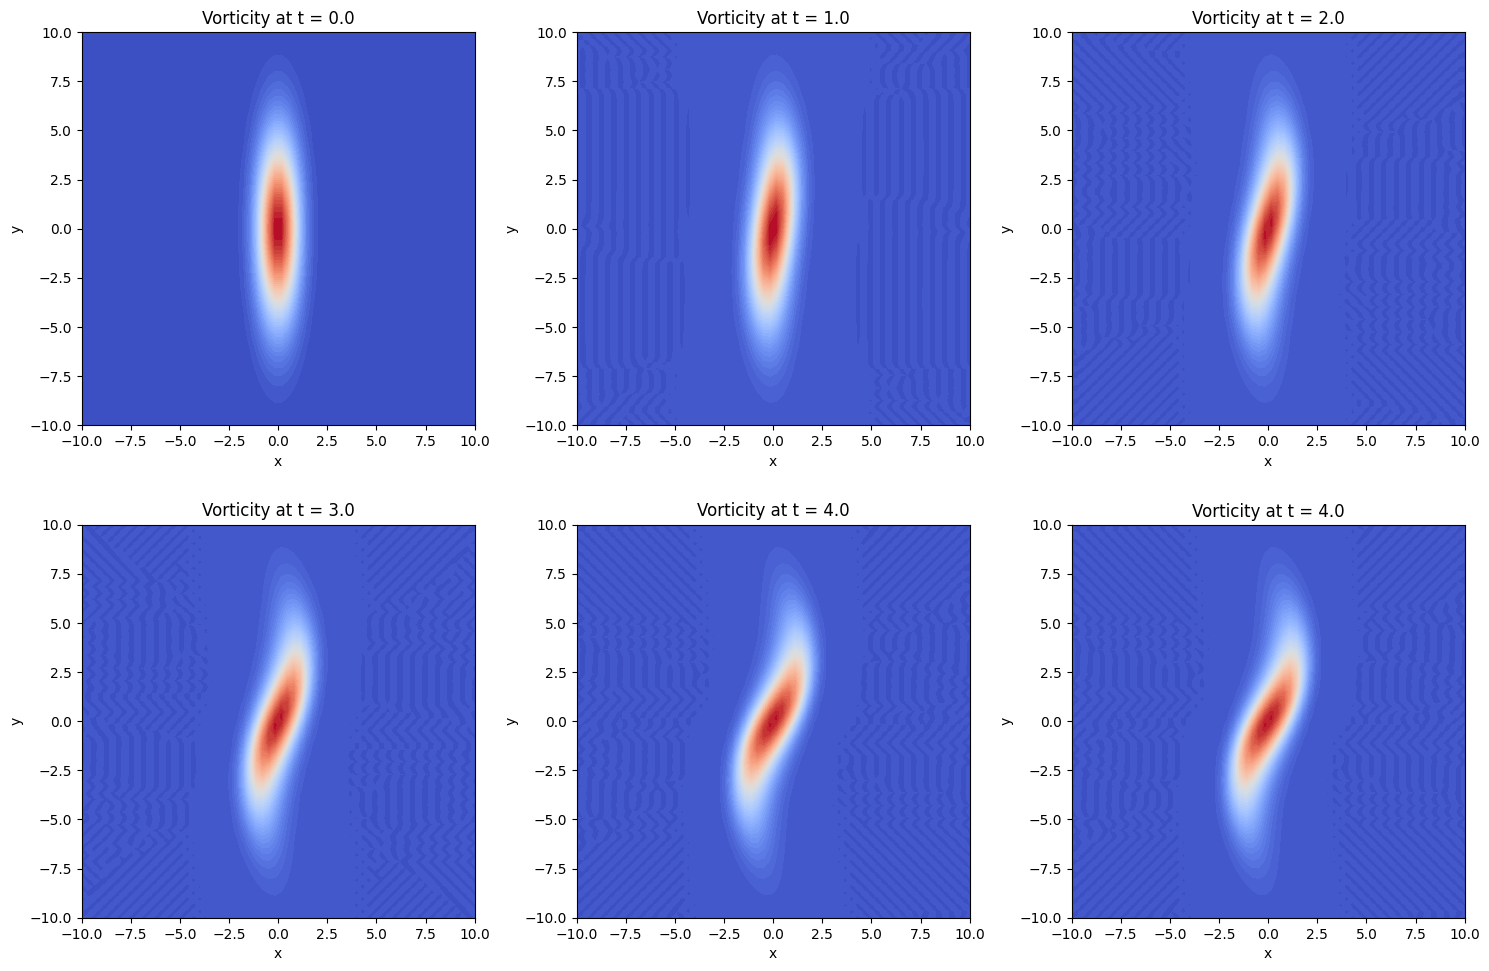

In [2]:
# Define spatial domain and grid
Lx, Ly = 20, 20  # Domain size
n = 64  # Number of grid points in each dimension
x = np.linspace(-Lx/2, Lx/2, n)
y = np.linspace(-Ly/2, Ly/2, n)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)

# Wavenumbers for FFT (with small correction)
kx = 2 * np.pi* fftfreq(n, d=dx)
ky = 2 * np.pi * fftfreq(n, d=dy)
kx[0] = 1e-6  # Avoid division by zero
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2

# Initial vorticity (elliptical Gaussian)
omega0 = np.exp(-X**2 - Y**2 / 20)

# Vorticity equation RHS function
def vorticity_rhs(t, omega_flat, nu, K2, KX, KY, n):
    omega = omega_flat.reshape((n, n))
    
    # Compute streamfunction in Fourier space
    omega_hat = fft2(omega)
    psi_hat = omega_hat / (-K2)
    psi = np.real(ifft2(psi_hat))
    
    # Compute derivatives
    psi_x = np.real(ifft2(1j * KX * psi_hat))
    psi_y = np.real(ifft2(1j * KY * psi_hat))
    omega_x = np.real(ifft2(1j * KX * omega_hat))
    omega_y = np.real(ifft2(1j * KY * omega_hat))

    # Compute RHS of vorticity equation
    rhs = nu * np.real(ifft2(-K2 * omega_hat)) + (psi_x * omega_y - psi_y * omega_x)
    return rhs.flatten()

# Parameters for the simulation
nu = 0.001  # Diffusion coefficient
t_span = (0, 4)  # Time range
t_eval = np.arange(0, 4.5, 0.5)  # Output times

# Solve using solve_ivp
A1 = solve_ivp(
    vorticity_rhs,
    t_span,
    omega0.flatten(),
    args=(nu, K2, KX, KY, n),
    method="RK45",
    t_eval=t_eval,
    vectorized=True,
).y

# Reshape the solution to grid form
solution = A1.reshape((n, n, len(t_eval)))

# Plot the results at selected time steps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
time_indices = [0, 2, 4, 6, 8, -1]  # Indices corresponding to t_eval
for ax, idx in zip(axes.flatten(), time_indices):
    ax.contourf(X, Y, solution[:, :, idx], levels=50, cmap='coolwarm')
    ax.set_title(f"Vorticity at t = {t_eval[idx]:.1f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()

**(b)** Solve these equations where for the streamline ($\nabla^2\psi = \omega$) use the following methods (NOTE: Take $A(0, 0) = 2$ instead of $A(0, 0) = −4$):
- A/b
- LU decomposition
- BICGSTAB
- GMRES
Compare all of these methods with your FFT routine developed in part **(a)**. You can informally check this
with the following code:

```python
import time
start_time = time.time() # Record the start time
end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
```

In particular, keep track of the computational speed of each method. Also, for BICGSTAB and GMRES, for the first few times solving the streamfunction equations, keep track of the residual as a function of the number of iterations needed to converge to the solution. Note that you should adjust the tolerance settings in BICGSTAB and GMRES to be consistent with your accuracy in the time-stepping. Experiment with the tolerance to see how much more quickly these iteration schemes converge.

**ANSWERS**: With $x, y \in [−10, 10]$, $n = 64$, $\omega(x, y, 0) = e^{(−x
^2 − y^2/20)}$ and $tspan = 0 : 0.5 : 4$, write out the solution of your numerical evolution for the vorticity from solve ivp as A2 for A/b and A3 for the LU method.

NOTE: For the LU method, when you solve you have to use the following code structure for $\textbf{Ax} = \textbf{b}$

```python
from scipy.linalg import lu, solve_triangular
P, L, U = lu(A)
Pb = np.dot(P, b)
y = solve_triangular(L, Pb, lower=True)
x = solve_triangular(U, y)
```

This will make to just forward- or backward-substitute for the LU since the solve command does not exploit that.

In [3]:
# Define parameters
L = 20  # domain length (from -10 to 10, so length is 20)
n = 64  # number of points in each direction
h = L / n  # grid spacing

# Create finite difference matrices with periodic boundary conditions
# 1D second derivative matrix with periodic boundary
e = np.ones(n)
D2 = spdiags([e, -2 * e, e], [-1, 0, 1], n, n).toarray()
D2[0, -1] = 1  # periodic boundary condition
D2[-1, 0] = 1
D2 = D2 / h**2  # scale by h^2

# 1D first derivative matrix with periodic boundary for x-derivative
D1x = spdiags([-e, e], [-1, 1], n, n).toarray()
D1x[0, -1] = -1  # periodic boundary condition
D1x[-1, 0] = 1
D1x = D1x / (2 * h)  # scale by 2h

# 1D first derivative matrix with periodic boundary for y-derivative
D1y = D1x.copy()  # Same structure due to symmetry

# Construct 2D Laplacian matrix (A = ∂²_x + ∂²_y)
I = eye(n).toarray()  # identity matrix
A = kron(I, D2) + kron(D2, I)
A[0, 0] = 2 / h**2  # Modify A(0, 0)

# Construct 2D partial derivative matrices (B = ∂_x, C = ∂_y)
B = diags([1/(2*h), -1/(2*h), -1/(2*h), 1/(2*h)], offsets=[n, -n, n**2 - n, n - n**2], shape=(n**2,n**2)) # partial derivative w.r.t. x
C = diags([np.concatenate([[1/(2*h)]*(n-1) + [0]]*n), 
           np.concatenate([[-1/(2*h)]*(n-1) + [0]]*n),
           np.concatenate([[-1/(2*h)] + [0]*(n-1)]*n),
           np.concatenate([[1/(2*h)] + [0]*(n-1)]*n)], offsets=[1, -1, n - 1, 1 - n], shape=(n**2, n**2))# partial derivative w.r.t. y

Elapsed time for A/b method: 2.33 seconds


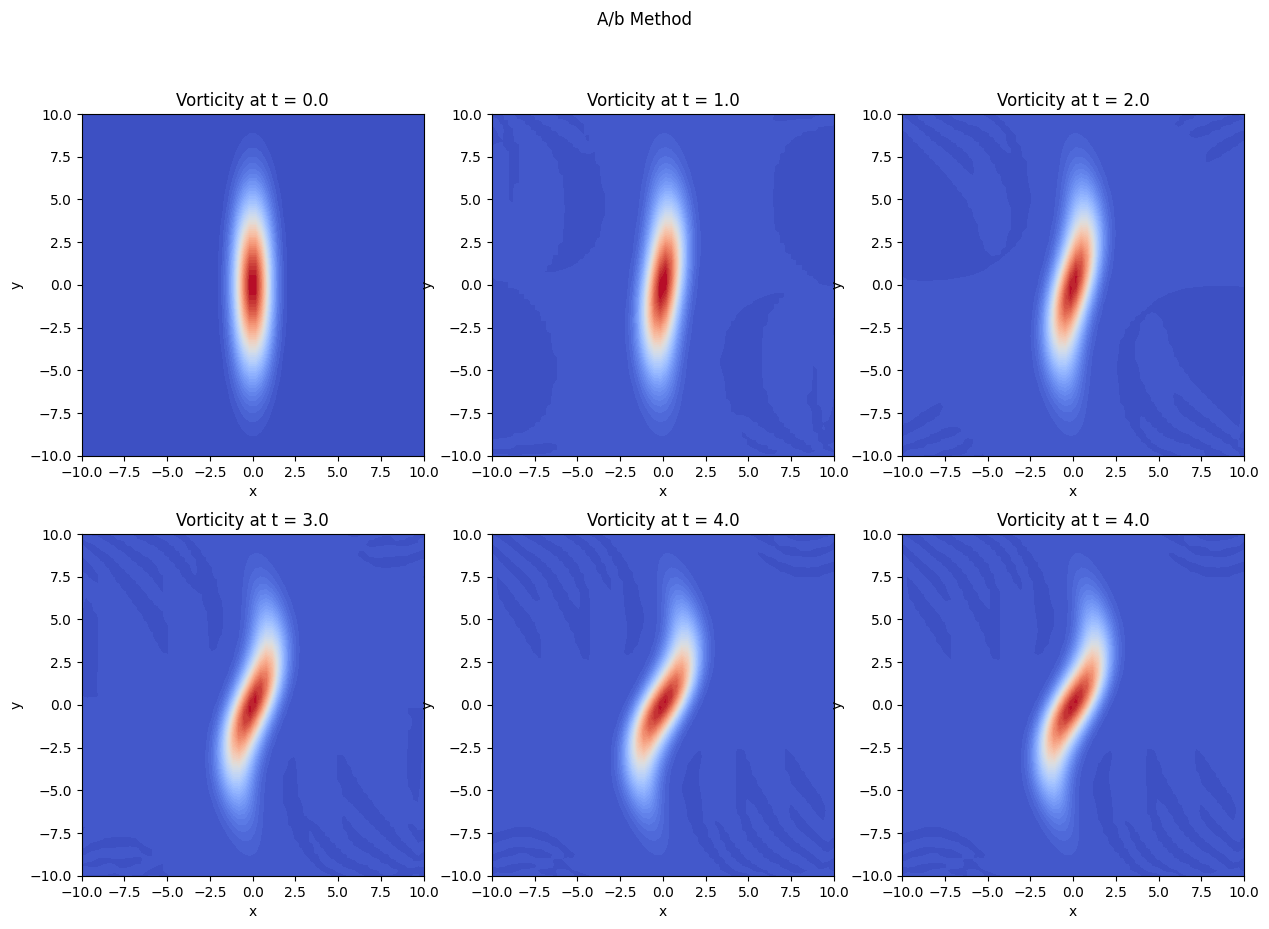

In [4]:
# Function to compute streamfunction using A/b method
def solve_streamfunction_ab(omega):
    return spsolve(A, omega)

# Define vorticity RHS for time evolution
def vorticity_rhs_ab(t, omega_flat):
    psi_flat = solve_streamfunction_ab(omega_flat)
    psi_x = (B @ psi_flat).reshape((n,n))
    psi_y = (C @ psi_flat).reshape((n,n))
    omega_x = (B @ omega_flat).reshape((n,n))
    omega_y = (C @ omega_flat).reshape((n,n))
    laplacian_omega = (A @ omega_flat).reshape((n,n))
    rhs = nu * laplacian_omega - (psi_x * omega_y - psi_y * omega_x)
    return rhs.flatten()

# Time evolution using solve_ivp
t_eval = np.arange(0, 4.5, 0.5)
start_time = time.time()
A2 = solve_ivp(
    vorticity_rhs_ab,
    [t_eval[0], t_eval[-1]],
    omega0.flatten(),
    t_eval=t_eval,
    method="RK45",
).y

elapsed_time_ab = time.time() - start_time

# Reshape solution for easier visualization
solution_ab = A2.reshape(n, n, len(t_eval))

# Display the timing result
print(f"Elapsed time for A/b method: {elapsed_time_ab:.2f} seconds")

# Plot the results at selected time steps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('A/b Method')
time_indices = [0, 2, 4, 6, 8, -1]  # Indices corresponding to t_eval
for ax, idx in zip(axes.flatten(), time_indices):
    ax.contourf(X, Y, solution_ab[:, :, idx], levels=50, cmap='coolwarm')
    ax.set_title(f"Vorticity at t = {t_eval[idx]:.1f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

Elapsed time for LU precomputation: 41.55 seconds
Elapsed time for LU method: 1.37 seconds


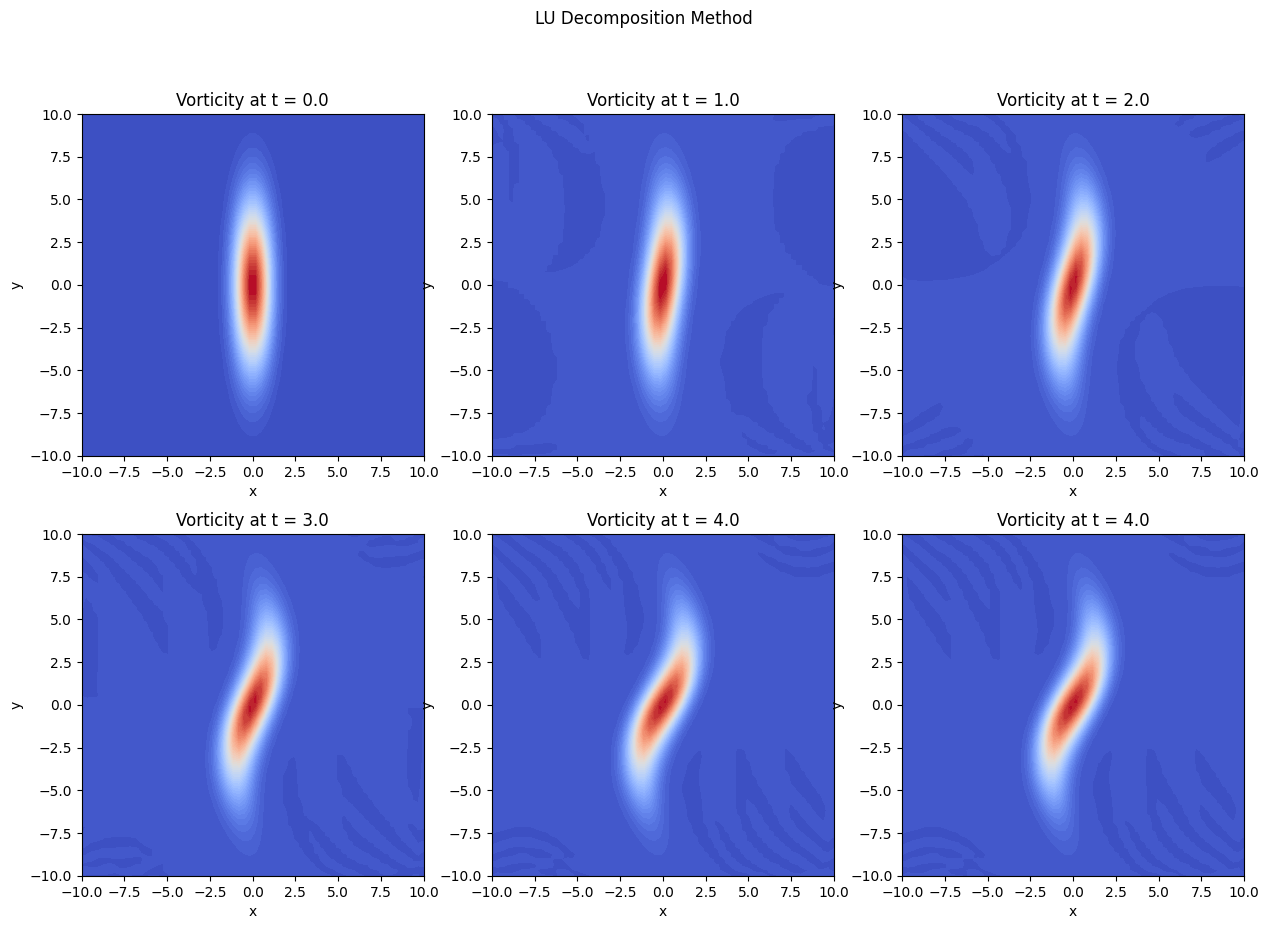

In [5]:
# Precompute LU decomposition for the Laplacian matrix (with A(0, 0) = 2)
start_time = time.time()
P, L, U = lu(A.toarray())
elapsed_time_lu_precomp = time.time() - start_time

# Function to compute streamfunction using LU decomposition
def solve_streamfunction_lu(omega_flat):
    Pb = P @ omega_flat
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    return psi

# Define vorticity RHS for time evolution using LU decomposition
def vorticity_rhs_lu(t, omega_flat):
    psi_flat = solve_streamfunction_lu(omega_flat)
    psi_x = (B @ psi_flat).reshape((n,n))
    psi_y = (C @ psi_flat).reshape((n,n))
    omega_x = (B @ omega_flat).reshape((n,n))
    omega_y = (C @ omega_flat).reshape((n,n))
    laplacian_omega = (A @ omega_flat).reshape((n,n))
    rhs = nu * laplacian_omega - (psi_x * omega_y - psi_y * omega_x)
    return rhs.flatten()

# Time evolution using solve_ivp with LU decomposition
start_time = time.time()
A3 = solve_ivp(
    vorticity_rhs_lu,
    [t_eval[0], t_eval[-1]],
    omega0.flatten(),
    t_eval=t_eval,
    method="RK45",
).y
elapsed_time_lu = time.time() - start_time

# Reshape solution for easier visualization
solution_lu = A3.reshape(n, n, len(t_eval))

# Display the timing results
print(f"Elapsed time for LU precomputation: {elapsed_time_lu_precomp:.2f} seconds")
print(f"Elapsed time for LU method: {elapsed_time_lu:.2f} seconds")

# Plot the results at selected time steps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('LU Decomposition Method')
time_indices = [0, 2, 4, 6, 8, -1]  # Indices corresponding to t_eval
for ax, idx in zip(axes.flatten(), time_indices):
    ax.contourf(X, Y, solution_lu[:, :, idx], levels=50, cmap='coolwarm')
    ax.set_title(f"Vorticity at t = {t_eval[idx]:.1f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

BICGSTAB did not converge (exit code: -10)
Elapsed time for BICGSTAB method: 2.39 seconds


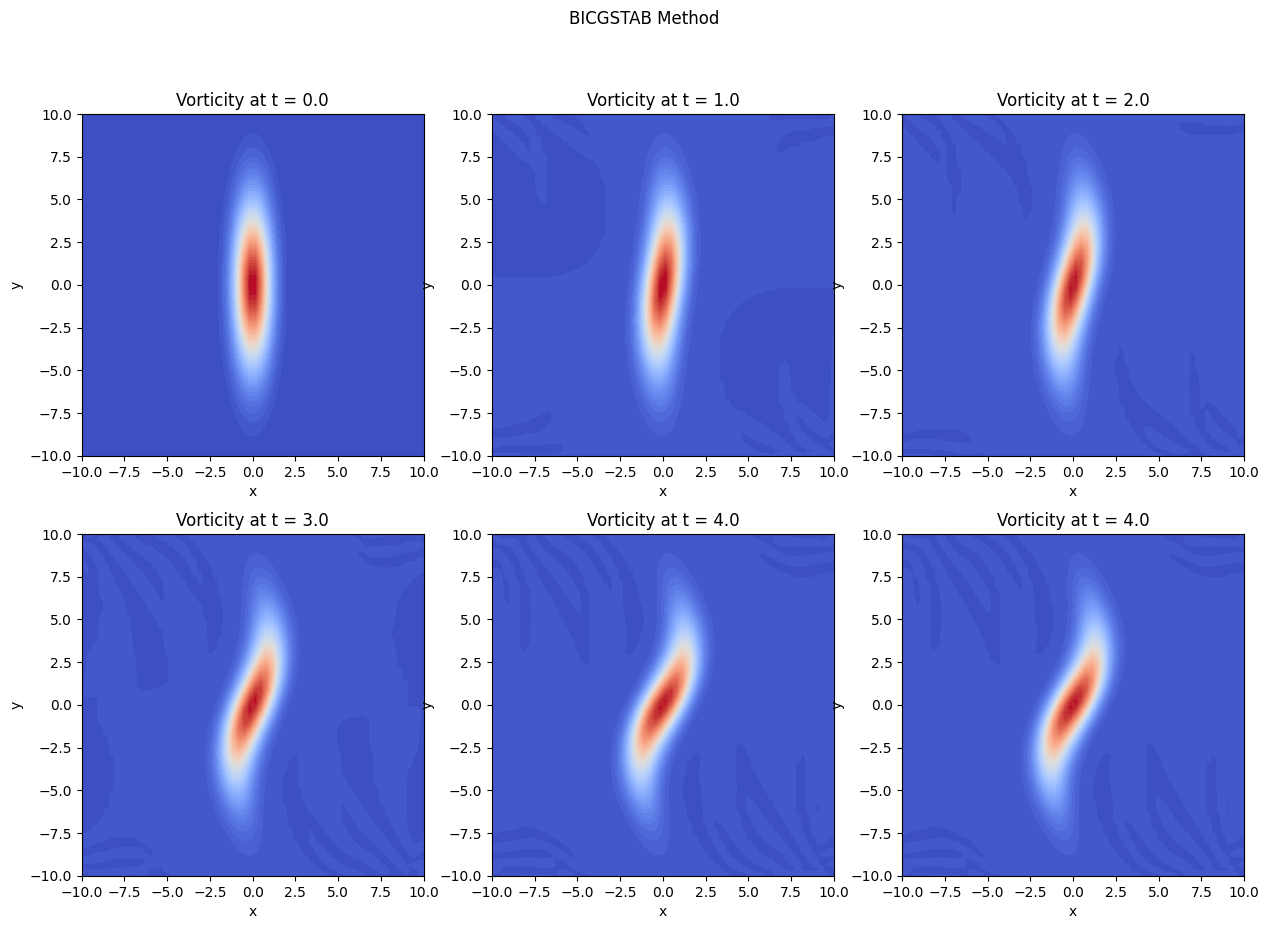

In [6]:
# List to store residuals
residuals_bicgstab = []

# Callback function to record residuals
def callback_bicgstab(residual_norm):
    residuals_bicgstab.append(residual_norm)

# Function to compute streamfunction using BICGSTAB
def solve_streamfunction_bicgstab(omega_flat, tol=1e-6):
    psi, exit_code = bicgstab(A, omega_flat, callback=callback_bicgstab)
    if exit_code != 0:
        print(f"BICGSTAB did not converge (exit code: {exit_code})")
    return psi

# Update the vorticity RHS to use BICGSTAB
def vorticity_rhs_bicgstab(t, omega_flat):
    omega = omega_flat.reshape((n, n))
    psi_flat = solve_streamfunction_bicgstab(omega_flat)
    psi_x = (B @ psi_flat).reshape((n,n))
    psi_y = (C @ psi_flat).reshape((n,n))
    omega_x = (B @ omega_flat).reshape((n,n))
    omega_y = (C @ omega_flat).reshape((n,n))
    laplacian_omega = (A @ omega_flat).reshape((n,n))
    rhs = nu * laplacian_omega - (psi_x * omega_y - psi_y * omega_x)
    return rhs.flatten()

# Time evolution using solve_ivp with BICGSTAB
start_time = time.time()
solution_bicgstab = solve_ivp(
    vorticity_rhs_bicgstab,
    [t_eval[0], t_eval[-1]],
    omega0.flatten(),
    t_eval=t_eval,
    method="RK45",
)
elapsed_time_bicgstab = time.time() - start_time

# Reshape solution for visualization
solution_bicgstab = solution_bicgstab.y.reshape(n, n, len(t_eval))

# Display the timing result
print(f"Elapsed time for BICGSTAB method: {elapsed_time_bicgstab:.2f} seconds")

# Plot the results at selected time steps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
time_indices = [0, 2, 4, 6, 8, -1]  # Indices corresponding to t_eval
fig.suptitle('BICGSTAB Method')
for ax, idx in zip(axes.flatten(), time_indices):
    ax.contourf(X, Y, solution_bicgstab[:, :, idx], levels=50, cmap='coolwarm')
    ax.set_title(f"Vorticity at t = {t_eval[idx]:.1f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

Elapsed time for GMRES method: 42.62 seconds


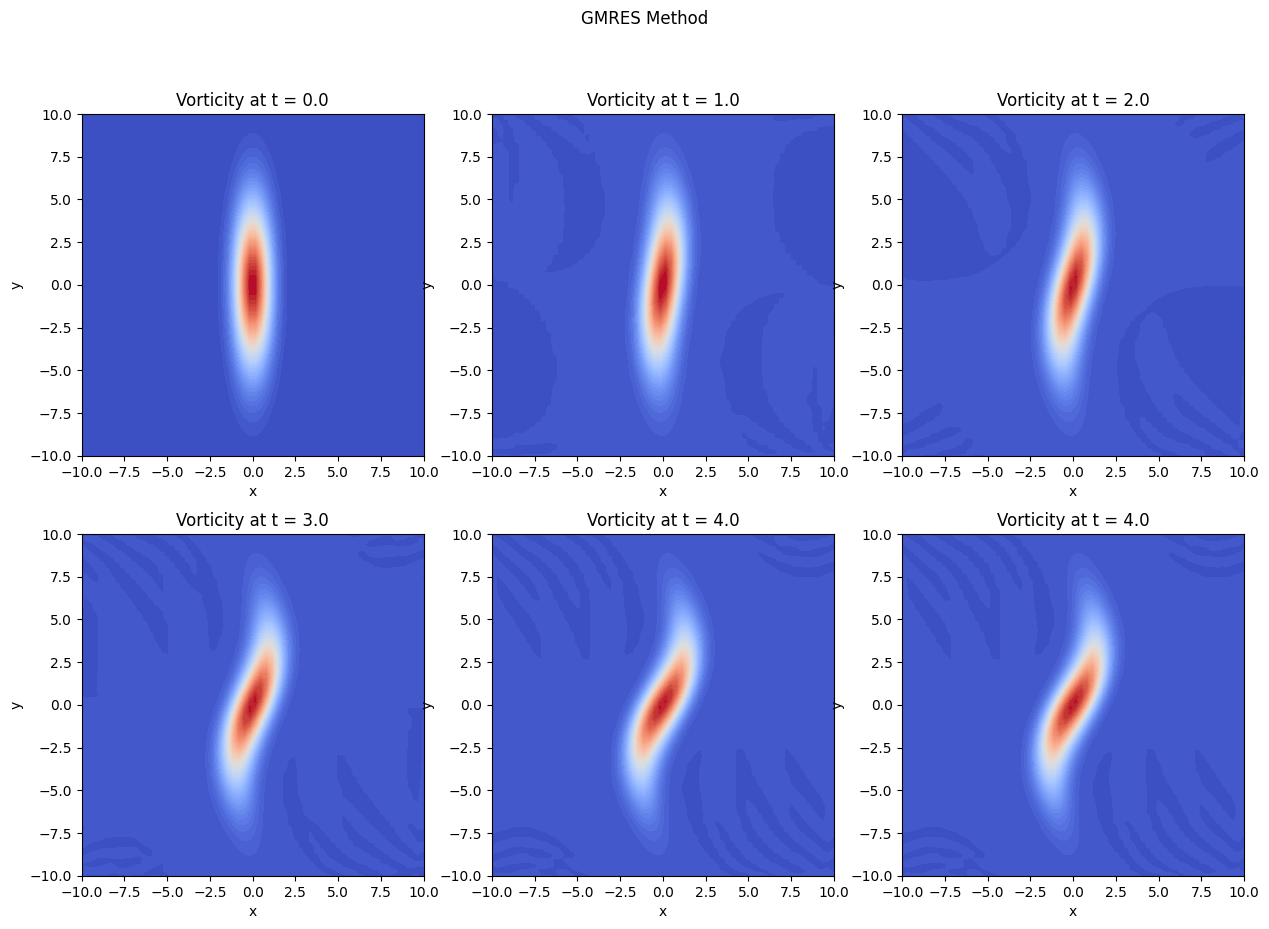

In [7]:
from scipy.sparse.linalg import gmres

# List to store residuals
residuals_gmres = []

# Callback function to record residuals
def callback_gmres(residual_norm):
    residuals_gmres.append(residual_norm)

# Function to compute streamfunction using GMRES
def solve_streamfunction_gmres(omega_flat, tol=1e-6):
    psi, exit_code = gmres(A, omega_flat, restart=10, callback=callback_gmres)
    if exit_code != 0:
        print(f"GMRES did not converge (exit code: {exit_code})")
    return psi

# Update the vorticity RHS to use GMRES
def vorticity_rhs_gmres(t, omega_flat):
    omega = omega_flat.reshape((n, n))
    psi_flat = solve_streamfunction_gmres(omega_flat)
    psi_x = (B @ psi_flat).reshape((n,n))
    psi_y = (C @ psi_flat).reshape((n,n))
    omega_x = (B @ omega_flat).reshape((n,n))
    omega_y = (C @ omega_flat).reshape((n,n))
    laplacian_omega = (A @ omega_flat).reshape((n,n))
    rhs = nu * laplacian_omega - (psi_x * omega_y - psi_y * omega_x)
    return rhs.flatten()

# Time evolution using solve_ivp with GMRES
start_time = time.time()
solution_gmres = solve_ivp(
    vorticity_rhs_gmres,
    [t_eval[0], t_eval[-1]],
    omega0.flatten(),
    t_eval=t_eval,
    method="RK45",
)
elapsed_time_gmres = time.time() - start_time

# Reshape solution for visualization
solution_gmres = solution_gmres.y.reshape(n, n, len(t_eval))

# Display the timing result
print(f"Elapsed time for GMRES method: {elapsed_time_gmres:.2f} seconds")

# Plot the results at selected time steps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
time_indices = [0, 2, 4, 6, 8, -1]  # Indices corresponding to t_eval
fig.suptitle('GMRES Method')
for ax, idx in zip(axes.flatten(), time_indices):
    ax.contourf(X, Y, solution_gmres[:, :, idx], levels=50, cmap='coolwarm')
    ax.set_title(f"Vorticity at t = {t_eval[idx]:.1f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

**(c)** Try out these initial conditions with your favorite/fastest solver on the streamfunction equations.
- Two oppositely “charged” Gaussian vorticies next to each other, i.e. one with positive amplitude, the
other with negative amplitude.
- Two same “charged” Gaussian vorticies next to each other.
- Two pairs of oppositely “charged” vorticies which can be made to collide with each other.
- A random assortment (in position, strength, charge, ellipticity, etc.) of vorticies on the periodic domain.
Try 10-15 vorticies and watch what happens.

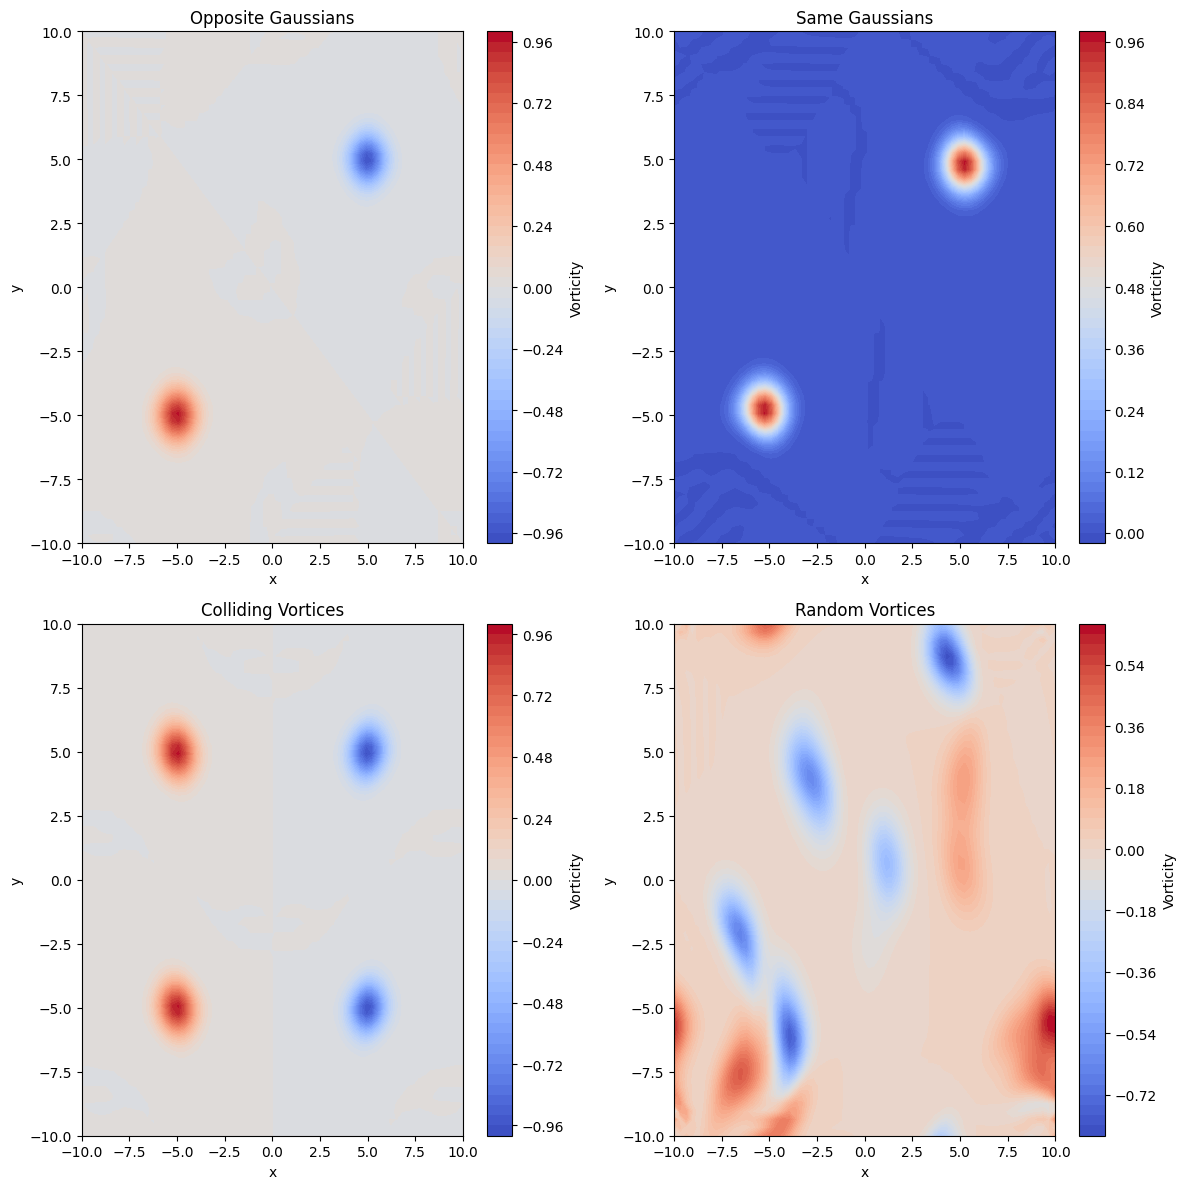

In [9]:
# Define initial conditions for the different cases

# 1. Two oppositely "charged" Gaussian vortices
def initial_condition_opposite_gaussians(X, Y):
    vortex1 = np.exp(-((X + 5) ** 2 + (Y + 5) ** 2))
    vortex2 = -np.exp(-((X - 5) ** 2 + (Y - 5) ** 2))
    return vortex1 + vortex2

# 2. Two same "charged" Gaussian vortices
def initial_condition_same_gaussians(X, Y):
    vortex1 = np.exp(-((X + 5) ** 2 + (Y + 5) ** 2))
    vortex2 = np.exp(-((X - 5) ** 2 + (Y - 5) ** 2))
    return vortex1 + vortex2

# 3. Two pairs of oppositely "charged" vortices
def initial_condition_colliding_vortices(X, Y):
    vortex1 = np.exp(-((X + 5) ** 2 + (Y + 5) ** 2))
    vortex2 = -np.exp(-((X - 5) ** 2 + (Y + 5) ** 2))
    vortex3 = np.exp(-((X + 5) ** 2 + (Y - 5) ** 2))
    vortex4 = -np.exp(-((X - 5) ** 2 + (Y - 5) ** 2))
    return vortex1 + vortex2 + vortex3 + vortex4

# 4. Random assortment of vortices
def initial_condition_random_vortices(X, Y, num_vortices=10):
    rng = np.random.default_rng()
    vortices = np.zeros_like(X)
    for _ in range(num_vortices):
        amplitude = rng.uniform(-1, 1)
        x_center = rng.uniform(-Lx / 2, Lx / 2)
        y_center = rng.uniform(-Lx / 2, Lx / 2)
        ellipticity = rng.uniform(1, 5)
        vortices += amplitude * np.exp(-((X - x_center) ** 2 + (Y - y_center) ** 2 / ellipticity))
    return vortices

# Run the numerical evolution for each case
cases = {
    "Opposite Gaussians": initial_condition_opposite_gaussians(X, Y),
    "Same Gaussians": initial_condition_same_gaussians(X, Y),
    "Colliding Vortices": initial_condition_colliding_vortices(X, Y),
    "Random Vortices": initial_condition_random_vortices(X, Y, num_vortices=15),
}

# Solve and visualize results
solutions = {}
for name, omega_init in cases.items():
    solution = solve_ivp(
        vorticity_rhs_ab,
        [t_eval[0], t_eval[-1]],
        omega_init.flatten(),
        t_eval=t_eval,
        method='RK45'
    )
    solutions[name] = solution.y.reshape(n, n, len(t_eval))

# Display final time-step vorticity fields for all cases
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
for ax, (name, omega_sol) in zip(axs.flatten(), solutions.items()):
    im = ax.contourf(X, Y, omega_sol[:, :, -1], levels=50, cmap='coolwarm')
    ax.set_title(name)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    cbar = fig.colorbar(im, ax=ax, label = "Vorticity")

plt.tight_layout()
plt.show()

**(d)** Make a 2-D movie of the dynamics. Color and coolness are key here. I would very much like to see
everyone’s movies and you can put these up on your github.

In [11]:
# Parameters for the simulation
nu = 0.001  # Diffusion coefficient
t_span = (0, 10)  # Time range
t_eval = np.arange(0, t_span[1] + 0.1, 0.1)  # Output times

# Solve using solve_ivp
solution_movie = solve_ivp(
    vorticity_rhs_ab,
    t_span,
    omega0.flatten(),
    method="RK45",
    t_eval=t_eval,
    vectorized=True,
)

# Reshape the solution to grid form
movie = solution_movie.y.reshape((n, n, len(t_eval)))

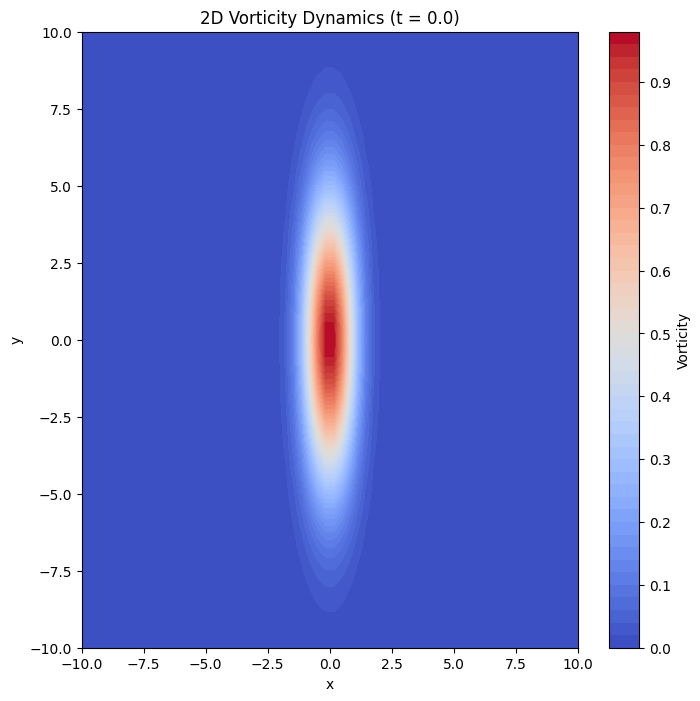

In [12]:
# # CODE FOR ANIMATION DEPENDS ON FFMPEG COMMENTED OUT FOR SUBMISSION PURPOSES

# # Animate the corrected solution
# fig, ax = plt.subplots(figsize=(8, 8))
# cmap = plt.cm.coolwarm
# contour = ax.contourf(X, Y, movie[:, :, 0], levels=50, cmap=cmap)
# colorbar = plt.colorbar(contour, ax=ax, label="Vorticity")
# ax.set_title("2D Vorticity Dynamics (Corrected)")
# ax.set_xlabel("x")
# ax.set_ylabel("y")

# def update(frame):
#     for c in ax.collections:
#         c.remove()
#     contour = ax.contourf(X, Y, movie[:, :, frame], levels=50, cmap=cmap)
#     ax.set_title(f"2D Vorticity Dynamics (t = {t_eval[frame]:.1f})")
#     return contour

# movie_length = t_eval[-1] * 1000 # milliseconds
# frames = len(t_eval)
# fps = (frames / movie_length) * 1000
# interval = (1 / fps)*1000

# anim = animation.FuncAnimation(
#     fig,
#     update,
#     frames=frames,
#     interval=interval,
#     repeat=True,
# )
# # anim.save("vorticity_dynamics.mp4", fps=fps) # uncomment to save animation to mp4 file
# video = anim.to_html5_video()
# HTML(video)

In [13]:
print(A1.shape)
print(A2.shape)
print(A3.shape)

(4096, 9)
(4096, 9)
(4096, 9)
